In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.wideVAE import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
from util import *
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    v_loss_sum = 0
    c_loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v, x_ = vae_model(data)
        # x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_.detach().view(-1,160,8,8))
        #logit = c_model(x_cat)
        v_loss, c_loss = loss_function_mean(data, target, x_hat, mean, log_v, logit)
        #print(loss)
        v_loss_sum += v_loss
        c_loss_sum += c_loss
        # if epoch_num % 2 == 1:
        if epoch_num <= 30:
            v_loss.backward()
            vae_optimizer.step()
            c_loss.backward()
        else:
            c_loss.backward()
            c_optimizer.step()
            v_loss.backward()
    return v_loss_sum, c_loss_sum

def eval_train(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('train error num:{}'.format(err_num))
def eval_test(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('test error num:{}'.format(err_num))


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def testtime_update(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel = 0):
    x_adv = x_adv.detach()
    x_hat_adv, mean, log_v, x_ = vae_model(x_adv)
    for _ in range(num):
        if (x_hat_adv != x_hat_adv).sum() > 0:
            print('nan Error')
            exit()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
            # loss = vae_loss_mean(x_adv, x_hat_adv, mean, log_v)
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
            # loss = vae_loss_sum(x_adv, x_hat_adv, mean, log_v)
        x_.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,channel,8,8))
        # print((logit_adv.data.max(1)[1] != target.data).float().sum())
    return logit_adv
    
def testtime_update_cifar_opt(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel=128, opti = 'adam'):
    x_adv = x_adv.detach()
    x_hat_adv, _, _, x_ = vae_model(x_adv)
    x_copy = x_.detach().clone()
    if opti == 'adam':
        opt = optim.Adam([x_copy], lr=learning_rate)
    elif opti == 'sgd':
        opt = optim.SGD([x_copy], lr=learning_rate, momentum=0.9)
    for _ in range(num):
        # opt.zero_grad()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
        x_.retain_grad()
        loss.backward(retain_graph=True)
        grad = torch.autograd.grad(loss, x_)
        # exit()
        with torch.no_grad():
            x_copy.grad = grad[0]
        # with torch.no_grad():
        #     x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        opt.step()
        x_ = x_copy.detach().clone()
        x_.requires_grad = True
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,channel,8,8))
    return logit_adv, x_hat_adv


In [3]:
def test(vae_model, c_model, source_model, channel=128, lr=0.01, num=50):
    err_num = 0
    err_adv = 0
    err_nat = 0
    c_model.eval()
    vae_model.eval()
    f = True
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,_,_,x_ = vae_model(data)
        logit = c_model(x_.view(-1,channel,8,8))
        err_nat += (logit.data.max(1)[1] != target.data).float().sum()
        logit_new, data_new = testtime_update_cifar_opt(vae_model, c_model, data, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_new = testtime_update_cifar(vae_model, c_model, data, target,learning_rate=0.1, num=100, channel=channel)
        # label = logit_calculate(logit, logit_new).to(device)
        # err_num += (label.data != target.data).float().sum()
        x_adv = pgd_cifar(vae_model, c_model, data, target, 20, 0.03, 0.003, channel=channel)
        # x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        _,_,_,x_ = vae_model(x_adv)
        logit_adv = c_model(x_.view(-1,channel,8,8))
        logit_adv_new, data_adv_new = testtime_update_cifar_opt(vae_model, c_model, x_adv, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_adv_new = testtime_update_cifar(vae_model, c_model, x_adv, target,learning_rate=0.1, num=100, channel=channel)
        if f:
            return logit, logit_adv, logit_new, logit_adv_new, target, data, data_new, x_adv, data_adv_new
        # label_adv = logit_calculate(logit_adv, logit_adv_new).to(device)
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=100)
        # _,_,_,x_ = vae_model(x_adv)
        # logit_adv = c_model(x_.view(-1,160,8,8))
        # err_adv += (label_adv.data != target.data).float().sum()
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_nat)
    print(err_num)
    print(err_adv)

In [4]:
source_model = WideResNet().to(device)
# source_model_path = './blackbox_pgd_model/model-wideres-epoch76.pt'
vae_model = wide_VAE(zDim=256, channel=[16,80,160]).to(device)
c_model = classifier(input_dim = 160).to(device)
vae_model_path = './model-checkpoint/cifar-vae-model-130.pt'
c_model_path = './model-checkpoint/cifar-c-model-130.pt'
# source_model.load_state_dict(torch.load(source_model_path))
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))

<All keys matched successfully>

In [5]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [6]:
logit, logit_adv,logit_nat_new, logit_adv_new, target,x,x_new,x_adv,x_adv_new = test(vae_model, c_model, source_model, channel=160, lr=0.01, num=100)

/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
label = logit_calculate(logit_adv, logit_adv_new)
label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())
print([i for i in range(200) if label[i]==target[i]])


tensor(47, device='cuda:0')
tensor(61, device='cuda:0')
[0, 1, 2, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 29, 31, 34, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 60, 62, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 112, 113, 114, 116, 117, 120, 121, 122, 123, 124, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 152, 153, 154, 155, 156, 159, 160, 161, 163, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 183, 185, 189, 192, 193, 196, 197, 199]


In [17]:
idx = 8
print(target[idx])
print(logit[idx])
print(logit_nat_new[idx])

tensor(3, device='cuda:0')
tensor([-16.0441, -27.8602,  -6.8359,   9.0967,  -4.5839,   4.7126,  -7.2971,
         -4.4091, -19.8075, -21.0435], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-16.2702, -27.0448,  -8.5208,  10.1232,  -5.7547,   5.6444,  -6.4167,
         -6.5775, -19.0267, -21.3731], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [18]:
print(logit_adv[idx])
print(logit_adv_new[idx])

tensor([-17.9364, -30.8385, -13.4672, -15.2182,  -6.3930,  20.7361, -16.4977,
         -3.2305, -23.0266, -29.4904], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-16.4618, -28.0625, -12.7587,  -7.7066,  -6.6621,  18.3913, -14.4558,
         -6.4320, -20.7951, -26.8548], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [24]:
x_hat,_,_,x_ = vae_model(x)

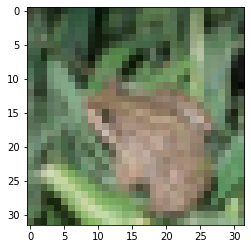

In [39]:
idex = 4
show_image(x, idx=idex)

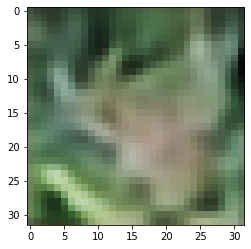

In [40]:
show_image(x_hat, idx=idex)

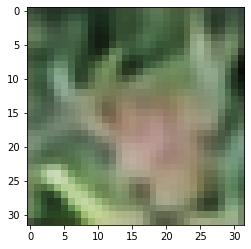

In [41]:
show_image(x_new, idx=idex)

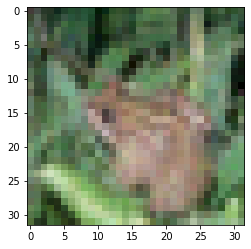

In [42]:
show_image(x_adv, idx=idex)

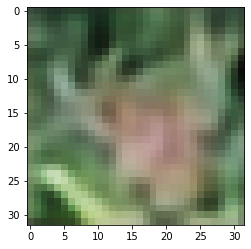

In [43]:
show_image(x_adv_new, idx=idex)

In [3]:
vae_model = wide_VAE(zDim=256).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
c_model = classifier().to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=0.01)
print('testing mode')
model_dir = './model-checkpoint'
test_num = 90
vae_model_path = '{}/cifar-vae-model-{}.pt'.format(model_dir, test_num)
c_model_path = '{}/cifar-c-model-{}.pt'.format(model_dir, test_num)
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))
c_model.eval()
vae_model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = Variable(data.data, requires_grad=True)
    # logit = model_pred(data, vae_model, c_model)
    # err_num += (logit.data.max(1)[1] != target.data).float().sum()
    # x_adv = pgd(vae_model, c_model, data, target, 20, 0.03, 0.003)
    # x_ = testtime_update(vae_model, x_adv ,learning_rate=0.15, num=100)
    _,_,_,x_ = vae_model(data)
    logit = c_model(x_.view(-1,160,8,8))
    break

testing mode
